In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import find_highest_wf
from ic_course_utils import replace_tag

%matplotlib inline

In [2]:
input_file = "data/HEe_fullsim.nexus.h5"
#input_file = "data/Kr83_fullsim.nexus.h5"

# Input file structure

The input file contains 1 group (`MC`) and five nodes (`configuration`, `hits`, `particles`, `sns_positions` and `sns_response`)

In [3]:
!ptdump $input_file

/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(35,)) ''
/MC/hits (Table(6947,)) ''
/MC/particles (Table(362,)) ''
/MC/sns_positions (Table(1804,)) ''
/MC/sns_response (Table(1741580,)) ''


The `configuration` node contains a table with the nexus configuration. Each row is a pair of (parameter name | nexus command, value).

In [4]:
!ptdump -vd $input_file:/MC/configuration

/MC/configuration (Table(35,)) ''
  description := {
  "param_key": StringCol(itemsize=300, shape=(), dflt=b'', pos=0),
  "param_value": StringCol(itemsize=300, shape=(), dflt=b'', pos=1)}
  byteorder := 'irrelevant'
  chunkshape := (32768,)
  Data dump:
[0] (b'event_type', b'other')
[1] (b'num_events', b'10')
[2] (b'saved_events', b'10')
[3] (b'interacting_events', b'10')
[4] (b'PmtR11410_binning', b'0.001000 mus')
[5] (b'SiPM_binning', b'1.000000 mus')
[6] (b'/PhysicsList/RegisterPhysics', b'G4EmStandardPhysics_option4')
[7] (b'/PhysicsList/RegisterPhysics', b'G4DecayPhysics')
[8] (b'/PhysicsList/RegisterPhysics', b'G4RadioactiveDecayPhysics')
[9] (b'/PhysicsList/RegisterPhysics', b'G4OpticalPhysics')
[10] (b'/PhysicsList/RegisterPhysics', b'NexusPhysics')
[11] (b'/PhysicsList/RegisterPhysics', b'G4StepLimiterPhysics')
[12] (b'/nexus/RegisterGeometry', b'NextNew')
[13] (b'/nexus/RegisterGenerator', b'SingleParticleGenerator')
[14] (b'/nexus/RegisterPersistencyManager', b'PersistencyM

The `hits` node contains a table describing the energy depositions in the active volume (a.k.a. hits). Each hit is described by a x,y,z position in mm, a time in ns, the deposited energy in MeV, the label of the volume where it was produced and an id number that identifies it uniquely within the collection of hits produced by a particle.

In [5]:
!ptdump -v $input_file:/MC/hits

/MC/hits (Table(6947,)) ''
  description := {
  "event_id": Int64Col(shape=(), dflt=0, pos=0),
  "x": Float32Col(shape=(), dflt=0.0, pos=1),
  "y": Float32Col(shape=(), dflt=0.0, pos=2),
  "z": Float32Col(shape=(), dflt=0.0, pos=3),
  "time": Float32Col(shape=(), dflt=0.0, pos=4),
  "energy": Float32Col(shape=(), dflt=0.0, pos=5),
  "label": StringCol(itemsize=100, shape=(), dflt=b'', pos=6),
  "particle_id": Int32Col(shape=(), dflt=0, pos=7),
  "hit_id": Int32Col(shape=(), dflt=0, pos=8)}
  byteorder := 'little'
  chunkshape := (32768,)


The `particles` node contains a table with information about all the particles that were tracked in the simulation (except for optical photons and ionization electrons).

In [6]:
!ptdump -v $input_file:/MC/particles

/MC/particles (Table(362,)) ''
  description := {
  "event_id": Int64Col(shape=(), dflt=0, pos=0),
  "particle_id": Int32Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=100, shape=(), dflt=b'', pos=2),
  "primary": Int8Col(shape=(), dflt=0, pos=3),
  "mother_id": Int32Col(shape=(), dflt=0, pos=4),
  "initial_x": Float32Col(shape=(), dflt=0.0, pos=5),
  "initial_y": Float32Col(shape=(), dflt=0.0, pos=6),
  "initial_z": Float32Col(shape=(), dflt=0.0, pos=7),
  "initial_t": Float32Col(shape=(), dflt=0.0, pos=8),
  "final_x": Float32Col(shape=(), dflt=0.0, pos=9),
  "final_y": Float32Col(shape=(), dflt=0.0, pos=10),
  "final_z": Float32Col(shape=(), dflt=0.0, pos=11),
  "final_t": Float32Col(shape=(), dflt=0.0, pos=12),
  "initial_volume": StringCol(itemsize=100, shape=(), dflt=b'', pos=13),
  "final_volume": StringCol(itemsize=100, shape=(), dflt=b'', pos=14),
  "initial_momentum_x": Float32Col(shape=(), dflt=0.0, pos=15),
  "initial_momentum_y": Float32Col(shape=(), d

The `sns_positions` node contains the information about the sensor positions (PMTs and SiPMs)

In [7]:
!ptdump -v $input_file:/MC/sns_positions

/MC/sns_positions (Table(1804,)) ''
  description := {
  "sensor_id": UInt32Col(shape=(), dflt=0, pos=0),
  "sensor_name": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "x": Float32Col(shape=(), dflt=0.0, pos=2),
  "y": Float32Col(shape=(), dflt=0.0, pos=3),
  "z": Float32Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (32768,)


Finally, the `sns_response` node contains a table with the information about photon hits in photosensors (sensor hits). The entries are recorded as (time bin, number of photons detected) pairs with the associated event number and sensor id information.

In [8]:
!ptdump -v $input_file:/MC/sns_response

/MC/sns_response (Table(1741580,)) ''
  description := {
  "event_id": Int64Col(shape=(), dflt=0, pos=0),
  "sensor_id": UInt32Col(shape=(), dflt=0, pos=1),
  "time_bin": UInt64Col(shape=(), dflt=0, pos=2),
  "charge": UInt32Col(shape=(), dflt=0, pos=3)}
  byteorder := 'little'
  chunkshape := (32768,)


# Input file data visualization

## Hits

There are several utilities in IC to read MC data from a file. This one is to load the hits (energy depositions in a volume)

In [9]:
from invisible_cities.io.mcinfo_io import load_mchits_df

We will load the hits  as a pandas DataFrame. The dataframe has a 3-level hierarchal index (a.k.a. multi-index). The index level increases from left to right: event id (level 0), particle id (level 1) and hit id (level 2)

Here, each row has exactly one value of the multi-index, i.e. one value of the triplet (event id, particle id, hit id).

In [10]:
all_hits = load_mchits_df(input_file)
all_hits.head()

x         y           z      time  \
event_id particle_id hit_id                                             
0        1           0      -0.951260 -0.076371  266.397339  0.003383   
                     1      -1.882917 -0.026344  266.755310  0.006766   
                     2      -2.794869  0.012764  267.162811  0.010150   
                     3      -3.689760  0.039850  267.607361  0.013533   
                     4      -4.539691  0.142567  268.120636  0.016913   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.004104  ACTIVE  
                     1       0.005989  ACTIVE  
                     2       0.004413  ACTIVE  
                     3       0.004041  ACTIVE  
                     4       0.015323  ACTIVE

We will now display the hits of a single event. For this we use the `loc` method to select rows from the dataframe. This method can perform partial index selections. `.loc[e]` will select the rows where `event_id = e`, `.loc[e,p]` or `.loc[(e,p)]` will select the rows where both `event_id = e` and `particle_id = p`, etc. Beware that pandas treats lists and tuples differently, see note (1) for details).

When we select a specific value of the outermost level, the remaining levels are shifted (1 becomes 0 and 2 becomes 1).

In [11]:
event_id   = 1 # this is not an index, but an absolute event number in the MC production. Starts at 0
event_hits = all_hits.loc[event_id]
event_hits.head()

x         y           z      time    energy   label
particle_id hit_id                                                            
1           0      -0.041238 -0.309806  265.150116  0.003385  0.004223  ACTIVE
            1       0.012165 -0.613109  264.199585  0.006767  0.004572  ACTIVE
            2       0.130249 -0.883323  263.244812  0.010149  0.005214  ACTIVE
            3       0.311862 -1.222115  262.322083  0.013533  0.005948  ACTIVE
            4       0.406903 -1.563990  261.387512  0.016917  0.003452  ACTIVE

The hits of an event are associated to the particle that created them. We will therefore loop over all particles (level 0 of the index) and plot them in the three 2D cartesian projections. The hits belonging to each track are displayed in a different colour.

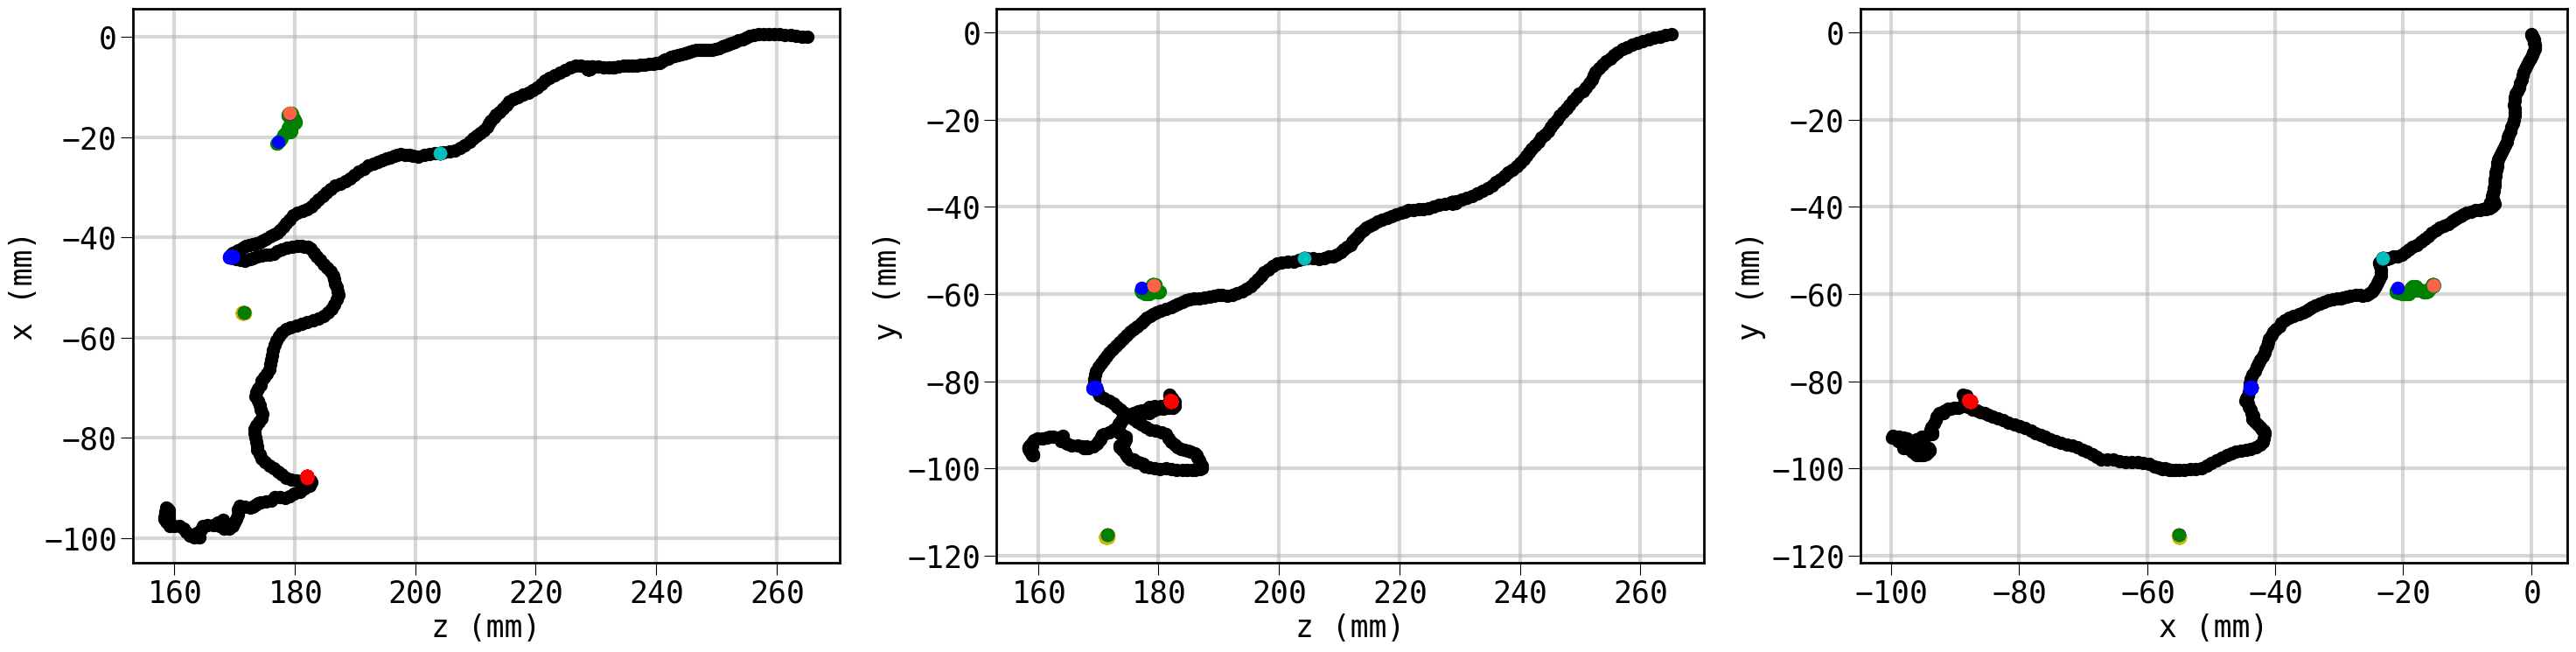

In [12]:
plt.figure(figsize=(30, 8))
for particle, hits in event_hits.groupby(level=0):
    plt.subplot(1, 3, 1); plt.plot(hits.z, hits.x, marker=".", ms=20); plt.xlabel("z (mm)"); plt.ylabel("x (mm)")
    plt.subplot(1, 3, 2); plt.plot(hits.z, hits.y, marker=".", ms=20); plt.xlabel("z (mm)"); plt.ylabel("y (mm)")
    plt.subplot(1, 3, 3); plt.plot(hits.x, hits.y, marker=".", ms=20); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

## Sensor responses (sensor hits)

We have the corresponding function to load the sensor responses

In [13]:
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df

The sensor responses are also loaded as a pandas DataFrame. This dataframe has a 2-level multi-index and in this case each row does *not* have a unique value of the multi-index. Here a pair (event id, sensor id) corresponds to several entries that can be used to reconstruct a pseudo-sensor waveform.

In [14]:
all_responses = load_mcsensor_response_df(input_file)
all_responses.head()

charge      time
event_id sensor_id                  
0        6011            1  259000.0
         6011            1  263000.0
         6011            1  266000.0
         6011            1  269000.0
         6011            1  270000.0

We will now display a PMT response in two ways. Note that the time column here represents *physical* time since the start of the simulation of the event. This is different from the waveform time that we will see later. 

In [15]:
event_id     = 1 # this is not a positional index, See note (2) for details
sensor_id    = 2 # this is not a sequential index. See note (3) for details
pmt_response = all_responses.loc[event_id, sensor_id]
pmt_response.head()

/tmp/ipykernel_301001/185551292.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  pmt_response = all_responses.loc[event_id, sensor_id]


charge  time
event_id sensor_id              
1        2               1   2.0
         2               3   9.0
         2               1  11.0
         2               1  12.0
         2               1  13.0

The easiest way to plot sensor hits is to histogram the number of detected photons in each time bin. This method also allows to visualize the waveform with a longer sampling period than the one used in nexus, which is often more useful. Notice the S1 pulse at t $\sim$ 0

Text(0, 0.5, 'Charge (pes/$\\mu$s)')

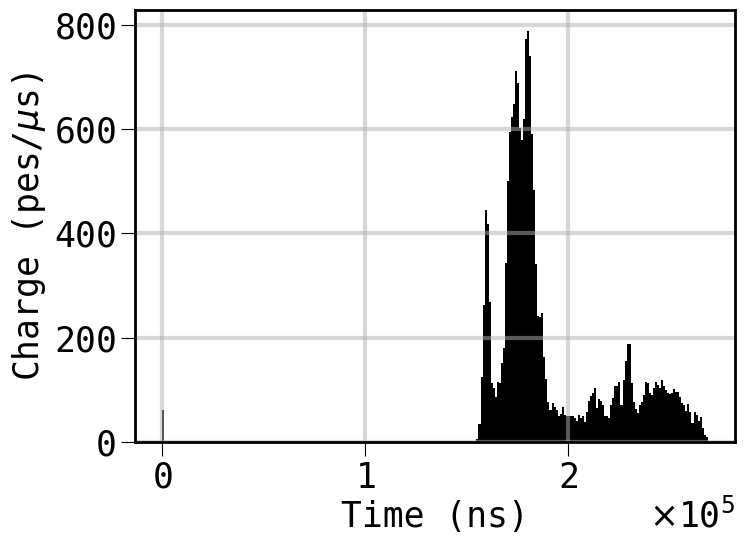

In [16]:
sp    = 1000 # sampling period in ns
times = np.repeat(pmt_response.time, pmt_response.charge)
bins  = np.arange(0, pmt_response.time.max() + 1, sp)
plt.hist(times, bins)
plt.xlabel("Time (ns)")
plt.ylabel("Charge (pes/$\mu$s)")

# Buffy

## Description

Sorts sensor responses into buffers, producing true waveforms (TWF) directly from the sensor hits. A TWF represents the signal amplitude (number of photoelectrons detected) of a given sensor as a function of time. This waveform does not contain any type of distortion or effect from the electronics.

The *physical* time from the nexus simulation is translated into a *buffer* time (time within the waveform) accounting for real-world conditions such as the DAQ trigger position and the maximum length of the buffer. The sensor responses are scanned to find triggerable pulses, which are used to position the data in the buffer. If more than one trigger is found separated from each other by more than a buffer width the nexus event can be split into multiple data-like triggers.

More details in the official documentation: 
https://next-exp-sw.readthedocs.io/en/latest/buffy.html

## Parameters

| Parameter | Type |  Description |
|:--------:|:--------:|:--------:|
| `max_time` | `float` | Maximum time after start of the event. All responses after `max_time` are discarded. (\*,\*\*) |
| `buffer_length` | `float` | Time span of the waveform (\*\*) |
| `pre_trigger` | `float` | Trigger position (\*\*) |
| `trigger_threshold` | `int` | Threshold for trigger candidate selection in photoelectrons |
| `rate` | `float` | Event rate for timestamp calculation |


(\*) Must be greater than `buffer_length`.

(\*\*) Must satisfy be a multiple of 1 $\mu$s

## Configuration

A typical Buffy configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [17]:
config_file = "config_files/buffy.conf"

In [18]:
!cat $config_file

compression       = 'ZLIB4'
event_range       = all
print_mod         = 1
detector_db       = 'new'
run_number        = -6400

max_time          =  10 *  ms
buffer_length     = 800 * mus
pre_trigger       = 100 * mus
trigger_threshold =   0

rate              = 1.5 * hertz

## City execution

In [19]:
output_file = replace_tag(input_file, "nexus", "buffy")
output_file

'data/HEe_fullsim.buffy.h5'

In [20]:
!city buffy $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 1
events processed: 2, event number: 2
events processed: 3, event number: 3
events processed: 4, event number: 4
events processed: 5, event number: 5
events processed: 6, event number: 6
events processed: 7, event number: 7
events processed: 8, event number: 8
events processed: 9, event number: 9


## Output

True waveforms for PMTs and SiPMs. Stored in the output file in the nodes
- `/pmtrd`
- `/sipmrd`

These are homogeneous arrays with shape (number of events, number of sensors, number of buffer samples), where the number of buffer samples is calculated from the ratio of `buffer_length` to the sensor sampling time included in the nexus file (possibly different for PMTs and SiPMs).

In [21]:
!ptdump -v $output_file:/pmtrd
!ptdump -v $output_file:/sipmrd

/pmtrd (EArray(10, 12, 800000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 524288)
/sipmrd (EArray(10, 1792, 800)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 327, 800)


### TWF visualization

<span class="burk">Careful with reading the entire `pmtrd` or `sipmrd` nodes of a large file in a single go, you might run out of memory!</span>

Note that the PMT is sampled at a much higher rate than the SiPM and therefore the number of photons per sample is much lower.

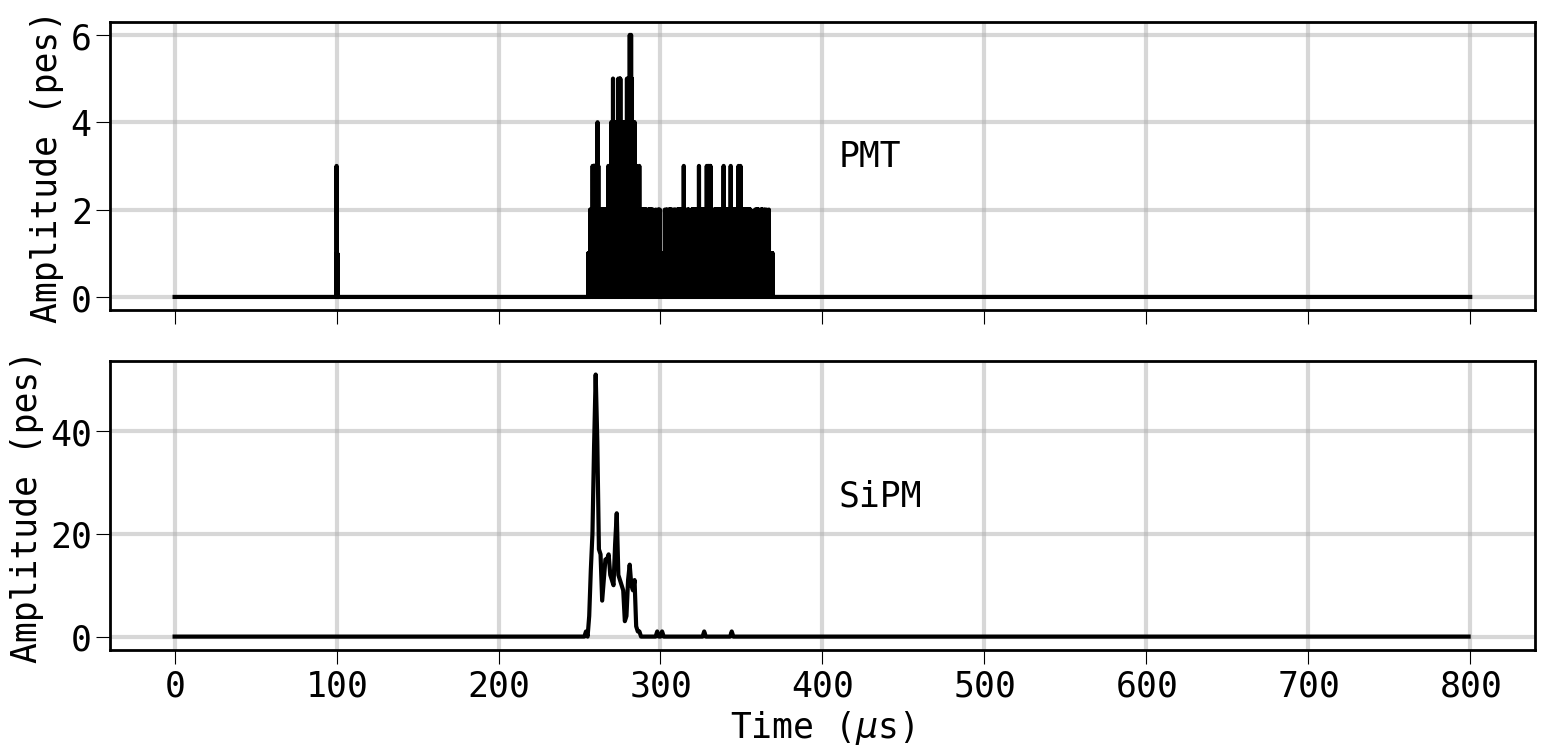

In [22]:
event_number = 1
with tb.open_file(output_file) as file:
    wf_pmt  = find_highest_wf(file.root. pmtrd, event_number)
    wf_sipm = find_highest_wf(file.root.sipmrd, event_number)
    
    sp_pmt  = 1e-3 # sampling period in mus
    sp_sipm = 1    # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
    ax1.plot(t_pmt , wf_pmt ); ax1.text(410, wf_pmt .max()/2, "PMT" );                                 ax1.set_ylabel("Amplitude (pes)")
    ax2.plot(t_sipm, wf_sipm); ax2.text(410, wf_sipm.max()/2, "SiPM"); ax2.set_xlabel("Time ($\mu$s)");ax2.set_ylabel("Amplitude (pes)")

# Notes

(1) the `loc` method can also select multiple indices at once using lists. This introduces a perhaps surprising behaviour: `.loc[(a,b,c)]` (with a tuple) and `.loc[[a,b,c]]` (with a list or an array) have different meanings. The former indexes a single row passing (or a group of them if the index has more levels) a single multi-index while the latter selects all the rows for which the first level of the index is either `a`, `b`, or `c`.

(2) Event numbers in MC are sequential starting at 0. For large productions (with more than one file), each file starts at a different event offset to prevent event id duplicates.

(3) The SiPMs are indexed based on two values: the dice board that hosts them (X, starting from 1) and their index within the dice board (Y). These two numbers are combined as X*1000 + Y. Therefore, SiPM 6027 is the number 27 in dice board 6. The SiPM index within a dice board starts at 0 in the lower left corner and increases upwards along each column like so:
```
.
.
.
2 10 18
1  9 17
0  8 16 ...
```